In [1]:
# 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# 경로지정
cd '/content/drive/MyDrive/Colab Notebooks/혁신성장/CNNPytorchCodes'

/content/drive/MyDrive/Colab Notebooks/혁신성장/CNNPytorchCodes


In [3]:
# 라이브러리 불러오기
import torch 
import torch.nn as nn 
import torch.optim as optim 
import torchvision 
import torchvision.transforms as transforms


In [4]:
# GPU로 연산하기 위한 코드
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
# Hyper parameter 지정

batch_size= 100 
learning_rate = 0.001 
num_epoch = 10 

In [6]:
# 데이터 train set과 test set으로 분리


# data argument : 이미지 회전과 같은 무작위(그러나 사실적인) 변환을 적용하여 훈련 세트의 다양성을 증가시키는 기술인 데이터 증강
transform = transforms.Compose( [transforms.ToTensor(),
                                 transforms.RandomCrop(32, padding=4),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
# data set 다운
trainset = torchvision.datasets.CIFAR10(root='./cifar10', train=True, download=True, transform=transform) 

# data set을 불러옴
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2) 

testset = torchvision.datasets.CIFAR10(root='./cifar10', train=False, download=True, transform=transform) 

test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2) 

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 deer  frog  frog plane


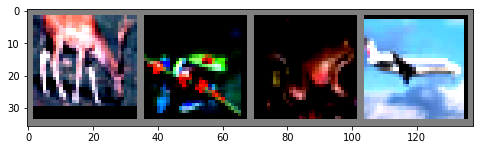

In [92]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(train_loader)
images, labels = dataiter.next()
plt.figure(figsize=(8, 8))
# 이미지 보여주기
imshow(torchvision.utils.make_grid(images[0:4]))
# 정답(label) 출력
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))
plt.show()


In [7]:
# batch normalization = out dim 값들을 정규화 시켜주는 과정
# BatchNorm2d = 4차원까지 값을 넣을 수 있음

def conv_2_block(in_dim,out_dim):
    model = nn.Sequential(
        nn.Conv2d(in_dim,out_dim,kernel_size=3,padding=1),
        nn.BatchNorm2d(out_dim),
        nn.ReLU(),

        nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1),
        nn.BatchNorm2d(out_dim),
        nn.ReLU(),
        nn.MaxPool2d(2,2)
    )
    return model


def conv_4_block(in_dim,out_dim):
    model = nn.Sequential(
        nn.Conv2d(in_dim,out_dim,kernel_size=3,padding=1),
        nn.BatchNorm2d(out_dim),
        nn.ReLU(),

        nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1),
        nn.BatchNorm2d(out_dim),
        nn.ReLU(),

        nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1),
        nn.BatchNorm2d(out_dim),
        nn.ReLU(),

        nn.Conv2d(out_dim,out_dim,kernel_size=3,padding=1),
        nn.BatchNorm2d(out_dim),
        nn.ReLU(),
        nn.MaxPool2d(2,2)
    )
    return model

In [8]:
# cifar10은 총 10개의 값이 있기 때문에 num_classes을 10으로 설정
# cifar10은는 컬러 이미지이기 때문에 3개의 채널을 가진다
# 따라서 32*32*3의 데이터 형태를 가진다

class VGG(nn.Module):
    def __init__(self, base_dim, num_classes=10):
        super(VGG, self).__init__()
        self.feature = nn.Sequential(
            conv_2_block(3,base_dim), # color      # input:32*32*3 / output:16*16*32
            conv_2_block(base_dim,2*base_dim),     # input:16*16*32 / output:8*8*64 
            # conv_2_block(2*base_dim,4*base_dim),
            conv_4_block(2*base_dim,4*base_dim),   # input:8*8*64 / output:4*4*128 
            conv_4_block(4*base_dim,8*base_dim),   # input:4*4*128 / output:2*2*256 
            conv_4_block(8*base_dim,8*base_dim),   # input:2*2*256 / output:1*1*256          
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(8*base_dim * 1 * 1, 1000),
            # 위에서 max pooling으로 픽셀 값이 다 나뉘어져서 1*1 이 나옴
            nn.ReLU(True),
            nn.Dropout(p = 0.2),  # Dropout 은 앙상블 러닝과 비슷한 효과를 내기 위해 사용함
                                  # 과적합을 막기 위해 사용함
                                  # 각 노드에게 0.2의 확률로 일을 수행하지 말라고 지정해줌
            nn.Linear(1000, 500),
            nn.ReLU(True),
            nn.Dropout(p = 0.2),
            nn.Linear(500, num_classes),
        )

    def forward(self, x):
        x = self.feature(x)
        x = x.view(x.size(0), -1)  # view = reshape
        x = self.fc_layer(x)
        return x
    

In [9]:
# model.to(device)는 GPU 연산을 하기 위하여 지정해준다
model = VGG(base_dim=32)
model = model.to(device)

# 손실함수 및 최적화함수를 설정
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 모델 자녀 노드의 이름과 모듈을 출력합니다.
for i in model.named_children():
    print(i)

('feature', Sequential(
  (0): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Conv2d(64, 128,

In [11]:
# 모델 학습
total_step = len(train_loader)
for epoch in range(num_epoch):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)      
        loss = loss_func(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epoch, i+1, total_step, loss.item()))

Epoch [1/10], Step [100/500], Loss: 0.4891
Epoch [1/10], Step [200/500], Loss: 0.6629
Epoch [1/10], Step [300/500], Loss: 0.4719
Epoch [1/10], Step [400/500], Loss: 0.6154
Epoch [1/10], Step [500/500], Loss: 0.6476
Epoch [2/10], Step [100/500], Loss: 0.6934
Epoch [2/10], Step [200/500], Loss: 0.6408
Epoch [2/10], Step [300/500], Loss: 0.5806
Epoch [2/10], Step [400/500], Loss: 0.2837
Epoch [2/10], Step [500/500], Loss: 0.4897
Epoch [3/10], Step [100/500], Loss: 0.6796
Epoch [3/10], Step [200/500], Loss: 0.4705
Epoch [3/10], Step [300/500], Loss: 0.5293
Epoch [3/10], Step [400/500], Loss: 0.4118
Epoch [3/10], Step [500/500], Loss: 0.4824
Epoch [4/10], Step [100/500], Loss: 0.4021
Epoch [4/10], Step [200/500], Loss: 0.5610
Epoch [4/10], Step [300/500], Loss: 0.5021
Epoch [4/10], Step [400/500], Loss: 0.6288
Epoch [4/10], Step [500/500], Loss: 0.6827
Epoch [5/10], Step [100/500], Loss: 0.5330
Epoch [5/10], Step [200/500], Loss: 0.5719
Epoch [5/10], Step [300/500], Loss: 0.5889
Epoch [5/10

In [56]:
model.eval()  # eval 선언은 dropout과 BN을 고정시키기 위함
with torch.no_grad():
  correct = 0
  total = 0
  for images, labels in test_loader:
      images = images.to(device) # gpu
      labels = labels.to(device) # gpu
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1) # (확률값 , class name) = max(데이터, 1(행))
      total += labels.size(0) # 한 번에 계산하는 batch_size의 갯수
      correct += (predicted == labels).sum().item() # item() = 딕셔너리 키 값 / 데이터 값만 불러옴
  print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

Test Accuracy of the model on the 10000 test images: 84.67 %


In [72]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device) # gpu
        labels = labels.to(device) # gpu
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels)
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))


Accuracy of plane : 97 %
Accuracy of   car : 93 %
Accuracy of  bird : 73 %
Accuracy of   cat : 67 %
Accuracy of  deer : 83 %
Accuracy of   dog : 78 %
Accuracy of  frog : 83 %
Accuracy of horse : 90 %
Accuracy of  ship : 93 %
Accuracy of truck : 82 %


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:    cat  ship  ship plane


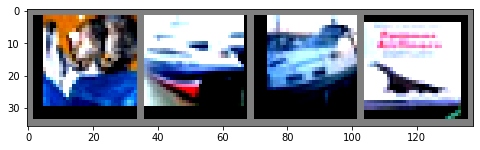

In [91]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

# print images
plt.figure(figsize=(8,8))
imshow(torchvision.utils.make_grid(images[0:4]))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
plt.show()